In [18]:
import os
import cv2
import skan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max

Text(0.5, 1.0, 'Segmented image')

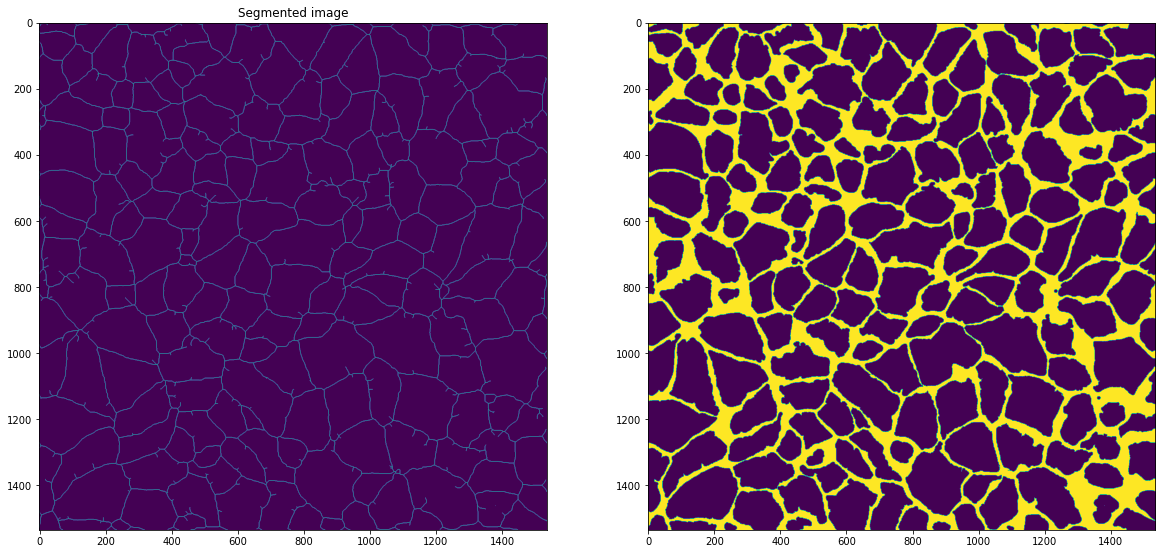

In [11]:
sk_img_path = "../data/raw/NegsiRNA/images/Skeletonized-CCJ/NegsiRNA_D2_NSj-SK.tif"
seg_img_path = "../data/raw/NegsiRNA/images/Segmented-CCJ/NegsiRNA_D2_NSj-BI.tif"
sk_img = cv2.imread(sk_img_path, cv2.IMREAD_UNCHANGED)
seg_img = cv2.imread(seg_img_path, cv2.IMREAD_UNCHANGED)

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(sk_img)
axes[0].set_title("Skeletonized image")
axes[1].imshow(seg_img)
axes[0].set_title("Segmented image")

## `j2j_distance_median`

This feature is computed from the skeletonized image. For each junction-to-junction branch in the skeleton, we compute the length of such branch, and then all those distances are aggregated using the median to generate an image-level feature.

More info about branches types in the [official documentation](https://skeleton-analysis.org/stable/getting_started/getting_started.html#measuring-the-length-of-skeleton-branches).

In [5]:
sk_data = skan.summarize(skan.Skeleton(sk_img))
sk_data

,skeleton-id,node-id-src,node-id-dst,branch-distance,branch-type,mean-pixel-value,stdev-pixel-value,image-coord-src-0,image-coord-src-1,image-coord-dst-0,image-coord-dst-1,coord-src-0,coord-src-1,coord-dst-0,coord-dst-1,euclidean-distance
0,1,1,300,15.727922,1,1.0,0.0,0.000000,102.000000,9.000000,114.000000,0.000000,102.000000,9.000000,114.000000,15.000000
1,1,7,300,48.727922,1,1.0,0.0,0.000000,159.000000,9.000000,114.000000,0.000000,159.000000,9.000000,114.000000,45.891176
2,1,8,223,14.619656,1,1.0,0.0,0.000000,225.000000,7.666667,236.333333,0.000000,225.000000,7.666667,236.333333,13.682917
3,1,10,224,12.370899,1,1.0,0.0,0.000000,276.000000,7.333333,266.666667,0.000000,276.000000,7.333333,266.666667,11.869663
4,2,11,13,2.000000,0,1.0,0.0,0.000000,362.000000,0.000000,364.000000,0.000000,362.000000,0.000000,364.000000,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1035,1,12567,39712,14.727922,1,1.0,0.0,1526.000000,277.000000,1535.000000,266.000000,1526.000000,277.000000,1535.000000,266.000000,14.212670
1036,1,12568,39609,10.429563,1,1.0,0.0,1526.750000,1220.000000,1533.000000,1212.000000,1526.750000,1220.000000,1533.000000,1212.000000,10.151970
1037,1,12760,39743,17.313708,1,1.0,0.0,1527.000000,1076.000000,1535.000000,1090.000000,1527.000000,1076.000000,1535.000000,1090.000000,16.124515
1038,1,12761,39545,6.962802,1,1.0,0.0,1528.666667,663.666667,1532.000000,658.000000,1528.666667,663.666667,1532.000000,658.000000,6.574361


We filter the dataframe keeping only the branches with type 2 (junction-to-junction branches), select the column `branch-distance` and compute the median.

In [7]:
j2j_distance_median = sk_data.loc[sk_data["branch-type"] == 2, "branch-distance"].median()
j2j_distance_median

46.855063979699494

## `branch_thinckness_voronoi_median`

This feature measures the "thickness" of each point in the skeleton of the CCJ segmented image. In other words, for each point in the skeleton, we measure how far to the background is that point in the original segmented image.

After computing the thickness in each point, we summarize that info using the median to create an image-level feature.

In [ ]:
def branch_thickness_voronoi(seg_img):
    """Computes the thickness of the branches using an approximation of the
    generalized Voronoi algorithm.

    Args:
        seg_img (np.array, shape=(n,n)): Binarized cell-cell junction image.

    Returns:
        np.array, shape=(n,n), dtype=float: Resulting image, where each point
            of the skeleton has the thickness in that point.
    """
    # Exact Euclidean distance transform. calculates the distance transform of
    # the input, by replacing each foreground (non-zero) element,
    # with its shortest distance to the background (any zero-valued element).
    distance = ndi.distance_transform_edt(seg_img)
    # In the previous step, we got an image with the "thickness" of each point
    # in the CCJ; almost what we want. We need now to keep only the "skeleton"
    # (and the thicknesss only in the skeleton points). To do that, we use the
    # waterhshed algorithm.
    local_maxi = peak_local_max(
        -distance, indices=False, footprint=np.ones((3, 3)), labels=seg_img
    )
    markers = ndi.label(local_maxi)[0]
    labels = watershed(distance, markers, watershed_line=True)
    mask = labels == 0
    distance_on_skel = distance.copy()
    distance_on_skel[~mask] = 0
    return distance_on_skel

Let's look at the generated image with the thickness in each point of the skeleton.

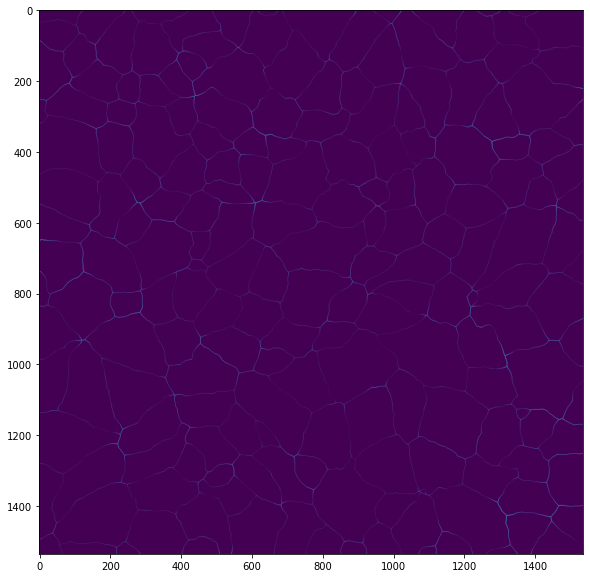

In [21]:
bt_img = branch_thickness_voronoi(seg_img).astype("float32")
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(bt_img)

Now we compute the feature

In [35]:
non_zero = bt_img[np.where(bt_img != 0)]
branch_thickness_voronoi_median = np.median(non_zero)
branch_thickness_voronoi_median

7.2111025